<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/02_GNN_message_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Graph Neural Network

After completing this chapter, you should be able to

  * Describe what is message passing in a GNN
  * Describe what is permutation equivariance and permutation invariance


A graph neural network (GNN) is a neural network with two defining attributes:

1. Its input is a graph
2. Its output is permutation equivariant

We can understand clearly the first point. Here, a graph permutation means re-ordering our nodes. In our methanol example above, we could have easily made the carbon be atom 1 instead of atom 4. Our new adjacency matrix would then be:

|    | 1  | 2  | 3  | 4  | 5  | 6  |
|:---|----|----|----|----|----|---:|
| 1  | 0  | 1  | 1  | 1  | 1  |  0 |
| 2  | 1  | 0  | 0  | 0  | 0  |  0 |
| 3  | 1  | 0  | 0  | 0  | 0  |  0 |
| 4  | 1  | 0  | 0  | 0  | 1  |  0 |
| 5  | 1  | 0  | 0  | 0  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


A GNN is permutation equivariant if the output change the same way as these exchanges. If you are trying to model a per-atom quantity like partial charge or chemical shift, this is obviously essential. If you change the order of atoms input, you would expect the order of their partial charges to similarly change.

Often we want to model a whole-molecule property, like solubility or energy. This should be **invariant** to changing the order of the atoms. To make an equivariant model invariant, we use read-outs (defined below).

### A simple GNN

We will often mention a GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. Let's see an example of a simple layer for a GNN:

\begin{equation}
f_k = \sigma\left( \sum_i \sum_j v_{ij}w_{jk}  \right)
\end{equation}

This equation shows that we first multiply every node ($v_{ij}$) feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. Is this equation permutation invariant? Yes, because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

Let's see an example that is similar, but not permutation invariant:

\begin{equation}
f_k = \sigma\left( \sum_i v_{ij}w_{ik}  \right)
\end{equation}

This is a small change. We have one weight vector per node now. This makes the trainable weights depend on the ordering of the nodes. Then if we swap the node ordering, our weights will no longer align. So if we were to input two methanol molecules, which should have the same output, but we switched two atom numbers, we would get different answers. These simple examples differ from real GNNs in two important ways: (i) they give a single feature vector output, which throws away per-node information, and (ii) they do not use the adjacency matrix. Let's see a real GNN that has these properties while maintaining permutation invariance --- or equivariance (swapping inputs swaps outputs the same way).

## Kipf & Welling GCN

One of the first popular GNNs was the Kipf & Welling graph convolutional network (GCN) {cite}`kipf2016semi`. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically the Kipf & Welling GCN.
Thomas Kipf has written an [excellent article introducing the GCN](https://tkipf.github.io/graph-convolutional-networks/).

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V}'$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neighbors, as determined by $\mathbf{E}$. The choice of averaging over neighbors is what makes a GCN layer permutation equivariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

$$
v_{il} = \sigma\left(\frac{1}{d_i}e_{ij}v_{jk}w_{kl}\right)
$$

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the output node feature, $d_i$ is the degree of node i (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have $1$s on the diagonal instead of $0$ by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs. You can view the GCN layer as a way to "communicate" between a node and its neighbors. The output for node $i$ will depend only on its immediate neighbors. For chemistry, this is not satisfactory. You can stack multiple layers though. If you have two layers, the output for node $i$ will include information about node $i$'s neighbors' neighbors. Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals: (i) it gives permutation equivariance by removing the effect of neighbor order and (ii) it prevents a change in magnitude in node features. A sum would accomplish (i) but would cause the magnitude of the node features to grow after each layer. Of course, you could ad-hoc put a batch normalization layer after each GCN layer to keep output magnitudes stable but averaging is easy.

In [1]:
# @title Install required packages.

!pip install rdkit

In [2]:
# @title import libraries
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl # plotting
import numpy as np # array manipulation
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw # chemical processing
import networkx as nx # visualization

In [3]:
my_elements = { 6: "C",  8: "O", 1: "H"}

In [4]:
def smiles2graph(sml):
    """Argument for the smiles2graph function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [5]:
nodes, adj = smiles2graph("CO")

<Figure size 1800x800 with 0 Axes>

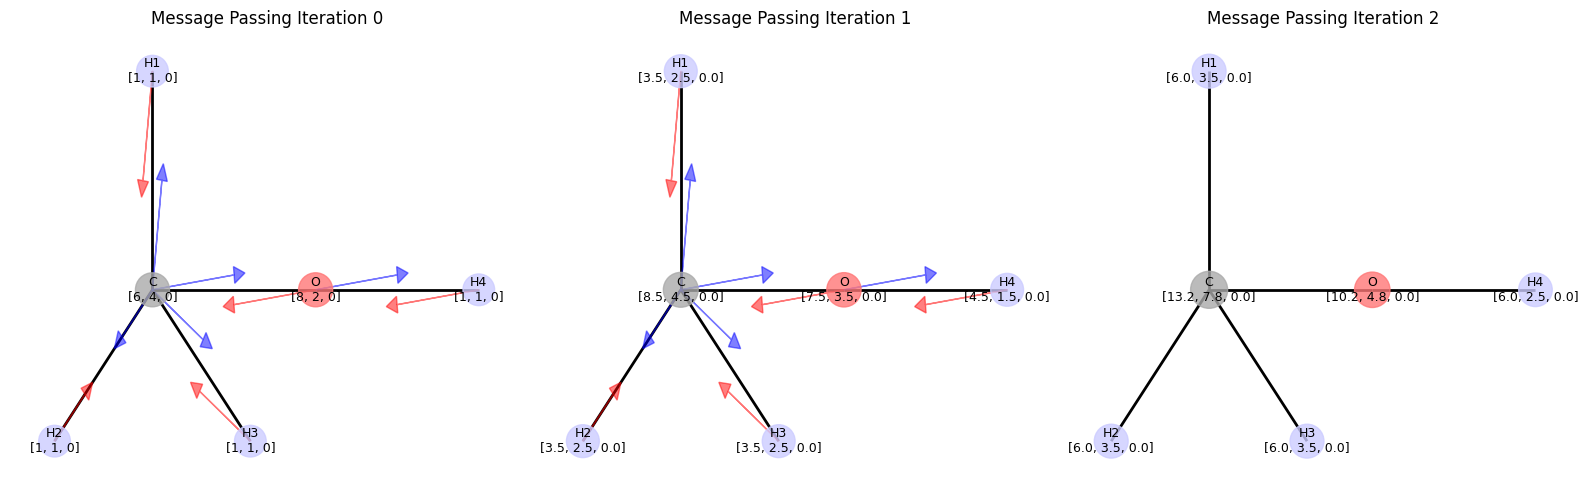

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure with two subplots side by side
plt.figure(figsize=(18, 8))

# Define atom positions for methanol (customize as needed)
pos = {
    'C': np.array([0, 0]),
    'O': np.array([1.5, 0]),
    'H1': np.array([0, 1.3]),
    'H2': np.array([-0.9, -0.9]),
    'H3': np.array([0.9, -0.9]),
    'H4': np.array([3.0, 0])
}

# Define atom colors
atom_colors = {
    'C': '#AAAAAA',  # gray
    'O': '#FF7777',  # red
    'H1': '#CCCCFF',  # light blue
    'H2': '#CCCCFF',  # light blue
    'H3': '#CCCCFF',  # light blue
    'H4': '#CCCCFF'   # light blue
}

# Define initial node feature vectors (simplified for visualization)
initial_features = {
    'C': [6, 4, 0],   # Atomic number, valence, charge
    'O': [8, 2, 0],
    'H1': [1, 1, 0],
    'H2': [1, 1, 0],
    'H3': [1, 1, 0],
    'H4': [1, 1, 0]
}

# Create a graph for methanol
G = nx.Graph()

# Add nodes with features
for atom, features in initial_features.items():
    G.add_node(atom, features=features, layer=0)

# Add edges (bonds)
G.add_edges_from([('C', 'O'), ('O', 'H4'), ('C', 'H1'), ('C', 'H2'), ('C', 'H3')])

# Define message passing function (simplified)
def message_passing(G, num_iterations=2):
    """Perform message passing on the graph for a given number of iterations"""
    graphs = [G.copy()]

    for iteration in range(num_iterations):
        new_G = G.copy()

        # For each node, aggregate messages from neighbors
        for node in G.nodes():
            neighbors = list(G.neighbors(node))

            # Get neighbor features
            neighbor_features = [G.nodes[neighbor]['features'] for neighbor in neighbors]

            # Simple aggregation: sum of neighbor features
            if neighbor_features:  # Check if the list is not empty
                aggregated = np.sum(neighbor_features, axis=0)

                # Update node features with a simple combination of old features and neighbor info
                old_features = np.array(G.nodes[node]['features'])
                new_features = 0.5 * old_features + 0.5 * aggregated
                new_G.nodes[node]['features'] = new_features.tolist()
                new_G.nodes[node]['layer'] = iteration + 1

        G = new_G
        graphs.append(G.copy())

    return graphs

# Perform message passing for 2 iterations
message_passed_graphs = message_passing(G, num_iterations=2)

# Visualization function for a specific iteration
def visualize_message_passing_at_iteration(iteration, ax, show_messages=True):
    """Visualize the graph at a specific message passing iteration"""
    current_G = message_passed_graphs[iteration]
    next_G = message_passed_graphs[min(iteration+1, len(message_passed_graphs)-1)]

    # Clear the axis
    ax.clear()

    # Draw nodes with size based on feature magnitude
    sizes = []
    node_colors = []
    for node in current_G.nodes():
        # Node size based on the sum of feature values
        size = 500 + 100 * np.sum(current_G.nodes[node]['features']) / 10
        sizes.append(size)
        node_colors.append(atom_colors[node])

    # Draw the graph with the current positions
    nx.draw_networkx_nodes(current_G, pos, ax=ax, node_size=sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(current_G, pos, ax=ax, width=2)

    # Draw node labels
    labels = {}
    for node in current_G.nodes():
        layer = current_G.nodes[node]['layer']
        features = [round(f, 1) for f in current_G.nodes[node]['features']]
        labels[node] = f"{node}\n{features}"

    nx.draw_networkx_labels(current_G, pos, labels=labels, font_size=9, ax=ax)

    # Show message passing arrows if requested and not at the last iteration
    if show_messages and iteration < len(message_passed_graphs) - 1:
        for edge in current_G.edges():
            source, target = edge
            source_pos, target_pos = pos[source], pos[target]

            # Draw arrows in both directions for bidirectional message passing
            # Calculate midpoints and shift slightly to avoid overlap
            mid = (source_pos + target_pos) / 2
            offset1 = np.array([0.1, 0.1])
            offset2 = np.array([-0.1, -0.1])

            # Draw arrow from source to target
            ax.arrow(source_pos[0], source_pos[1],
                    (mid + offset1)[0] - source_pos[0], (mid + offset1)[1] - source_pos[1],
                    head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.5,
                    length_includes_head=True)

            # Draw arrow from target to source
            ax.arrow(target_pos[0], target_pos[1],
                    (mid + offset2)[0] - target_pos[0], (mid + offset2)[1] - target_pos[1],
                    head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.5,
                    length_includes_head=True)

    ax.set_title(f'Message Passing Iteration {iteration}')
    ax.axis('off')

# Create a function to display multiple iterations
def visualize_message_passing(iterations=3):
    fig, axes = plt.subplots(1, iterations, figsize=(16, 5))

    for i in range(iterations):
        if iterations == 1:
            ax = axes
        else:
            ax = axes[i]
        visualize_message_passing_at_iteration(i, ax, show_messages=(i < iterations-1))

    plt.tight_layout()
    plt.show()

# Display iterations 0, 1, and 2
visualize_message_passing(iterations=3)

# ----------- Animation version -----------
# For a more interactive visualization, create an animation

def create_message_passing_animation():
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        visualize_message_passing_at_iteration(frame % 3, ax)
        return ax,

    ani = FuncAnimation(fig, update, frames=3, interval=1500, blit=False)
    plt.close()  # Don't display the figure
    return ani

# Create and display the animation
animation = create_message_passing_animation()
HTML(animation.to_jshtml())

### Exercise

Let's repeat the same process for Ethanol `(CCO)`.

1. Convert the smiles into the graph.
2. How many nodes the graph contain? What is the number of rows and columns for the graph?
3. Show the adjancy matrix for the Ethanol
4. show the adjacancy list for ethanol
5. Perform one-step of message passing for each atom in this molecules. Consider the identity matrix for weights.